# The pyBLP Module (Jeff Gortmaker and Christopher Conlon) ![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alexcann/python_and_pyBLP_intro/blob/master/pyBLP_presentation.ipynb)
---

## Structure 

0. Why pyBLP?
1. Installing and Importing Modules
2. Theory Refresh
3. Estimation w/o Demographics
4. Estimation w/ Demographics

---
---
## 0. Why [pyBLP](https://pyblp.readthedocs.io/en/stable/index.html)?

* Pros:
  * Well written
  * Easy to use $\rightarrow$ we can have estimates within minutes.
  * Compareability and Reproducability (Same data + Same specification $\rightarrow$ Same results).

* Cons:
  * Without reading through the code we never know what is really done.
  * It is hard to adjust the code.
  * Maintainance.


***Words of caution:***
> **Never blindely use prebuild estimators.**

***(Subjective) best practice:***
> **Write an own estimator and compare results + go through the source code.**

***(Subjective) second best practice:***
> **Read the [companion-paper](https://jeffgortmaker.com/files/pyblp.pdf) and the [documentation](https://pyblp.readthedocs.io/en/stable/api.html) of every module/function.**

---
---
## 1. Installing and Importing Modules

Dependencies:
* `numpy:` for linear algebra and optimization.
* `pandas:` for data handeling.
* `scipy:` for the optimization toolbox.
* `sympy:` for symbolic programming.
* `patsy:` R-style regression equations e.g. C(X) for categorical. 




In [ ]:
!pip install numpy pandas scipy sympy patsy pyblp 

import pyblp
import numpy as np
import pandas as pd
import sympy as sy
import matplotlib.pyplot as plt

---
---
## 2. Theory Refresh

### Estimation

* The (indirect) utility individual $i$ recieves from product $j$ in market $t$ is given by:

$$u_{ijt} = \alpha_i p_{jt} + x_{jt} \beta_i^\text{ex} + \xi_{jt} + \epsilon_{ijt},\;\;\text{with $\alpha_i$ endogenous and $\beta_i^{\text{ex}}$ exogenous.}$$
  
$ $
* After integrating out the $\epsilon_{ijt}$ market shares are given by:
$$s_{jt}(\alpha, \beta, \theta) = \int \frac{\exp(\alpha_i p_{jt} + x_{jt} \beta_i^\text{ex} + \xi_{jt})}{1 + \sum_k \exp(\alpha_i p_{jt} + x_{kt} \beta_i^\text{ex} + \xi_{kt})} f(\alpha_i, \beta_i \mid \theta).$$

$ $ 
* Rewriting the model as mean utility $\delta_{jt} = \alpha p_{jt} + x_{jt} \beta^\text{ex} + \xi_{jt}$ and individual deviations $\mu_{ijt}(\theta)$:

$$s_{jt}(\delta_{jt}, \theta) = \int \frac{\exp(\delta_{jt} + \mu_{ijt})}{1 + \sum_k \exp(\delta_{kt} + \mu_{ikt})} f(\mu_{it} | \theta).$$


$ $
* Given a guess for $\theta$ "invert" market shares $s_{jt} = s_{jt}(\delta, \theta)$ to find $\delta_{jt}$ and perform a linear IV GMM to estimate $\alpha$ and $\beta^{\text{ex}}$ using:
$$\delta_{jt}(\theta) = \alpha p_{jt} + x_{jt} \beta^\text{ex} + \xi_{jt}.$$


$ $
* Obtain the predicted residuals $\hat{\xi}_{jt}(\theta)$ nad combin them instruments $z_{jt}$ to form moments.

$$\bar{g}(\theta) =\frac{1}{N} \sum_{j,t} z_{jt}' \hat{\xi}_{jt}(\theta).$$

$ $
* Update the $\theta$ guess based on the resulting GMM-Function.

### The Random Coeficcients
* $f(\beta_i \mid \theta)$ with $\beta_i=(\alpha_i, \beta_i^{ex})$ follows a multivariate normal distribution:

$$\beta_i \sim N(\beta + \Pi d_i, \Sigma). \;\;\text{where $d_i$ a demographics vector}$$


---
---
## The Fake Cereal Data from [Nevo (2000)](https://pyblp.readthedocs.io/en/stable/references.html#nevo-2000).

Just like in the logit case we have the same reserved field names in `product_data`:

* `market_ids` are the unique market identifiers (subscript $t$) and combine combines `city_ids` with `quaters`.
* `product_ids` are unique prduct identifiers (sbscript $j$) and combine `brand_ids` and `firm_ids`  
* `shares` specifies the market share which need to be between zero and one, and within a market ID, $\sum_{j} s_{jt} < 1$.
* `prices` are prices $p_{jt}$ normalized to some size. These have some special properties and are _always_ treated as endogenous.
* `sugar` and `mushy` are product characteristics.
* `demand_instruments0`, `demand_instruments1`, ... numbered demand instruments. These represent only the _excluded_ instruments. The exogenous regressors in $X_1$ (of which $X_2$ is typically a subset) will be automatically added to the set of instruments.

In [ ]:
# loading the data (the tutorial data is part of pyblp)
product_data = pd.read_csv(pyblp.data.NEVO_PRODUCTS_LOCATION)
# print the first five values
product_data.head()

,market_ids,city_ids,quarter,product_ids,firm_ids,brand_ids,shares,prices,sugar,mushy,demand_instruments0,demand_instruments1,demand_instruments2,demand_instruments3,demand_instruments4,demand_instruments5,demand_instruments6,demand_instruments7,demand_instruments8,demand_instruments9,demand_instruments10,demand_instruments11,demand_instruments12,demand_instruments13,demand_instruments14,demand_instruments15,demand_instruments16,demand_instruments17,demand_instruments18,demand_instruments19
0,C01Q1,1,1,F1B04,1,4,0.012417,0.072088,2,1,-0.215973,0.040573,-3.247948,-0.523938,-0.232460,0.006833,3.139740,-0.574786,0.206220,0.177466,2.116358,-0.154708,-0.005796,0.014538,0.126244,0.067345,0.068423,0.034800,0.126346,0.035484
1,C01Q1,1,1,F1B06,1,6,0.007809,0.114178,18,1,-0.245239,0.054742,-19.832461,-0.180520,0.014689,0.000799,0.287654,0.032940,0.105121,-0.287562,-7.374091,-0.576412,0.012991,0.076143,0.029736,0.087867,0.110501,0.087784,0.049872,0.072579
2,C01Q1,1,1,F1B07,1,7,0.012995,0.132391,4,1,-0.176459,0.046596,-2.878531,-0.284219,-0.215537,-0.031869,2.886274,-0.749765,-0.478956,0.214739,2.187872,-0.207346,0.003509,0.091781,0.163773,0.111881,0.108226,0.086439,0.122347,0.101842
3,C01Q1,1,1,F1B09,1,9,0.005770,0.130344,3,0,-0.121401,0.048760,-2.059918,-0.328412,-0.222070,-0.031474,4.453110,0.255675,-0.472967,0.356098,2.704576,0.040748,-0.003724,0.094732,0.135274,0.088090,0.101767,0.101777,0.110741,0.104332
4,C01Q1,1,1,F1B11,1,11,0.017934,0.154823,12,0,-0.132611,0.039628,-6.137598,-0.138625,-0.189365,-0.043747,-3.554651,0.138821,-0.688678,0.260273,1.261242,0.034836,-0.000568,0.102451,0.130640,0.084818,0.101075,0.125169,0.133464,0.121111


In [ ]:
# descriptives

# General Info
print('General Info:')
num_of_cities = product_data.city_ids.nunique()
num_of_markets = product_data.market_ids.nunique()
num_of_quarters = int(num_of_markets/num_of_cities)
print('\t - {} cities \n \t - {} quarters \n \t - {} markets.\n'\
      .format(num_of_cities, num_of_quarters, num_of_markets))

# Product Info
print('Product Info:')
num_of_firms = product_data.firm_ids.nunique()
num_of_brands = product_data.brand_ids.nunique()
print('\t - {} products \n \t - {} firms'.format(num_of_brands, num_of_firms))

General Info:
	 - 47 cities 
 	 - 2 quarters 
 	 - 94 markets.

Product Info:
	 - 23 products 
 	 - 5 firms


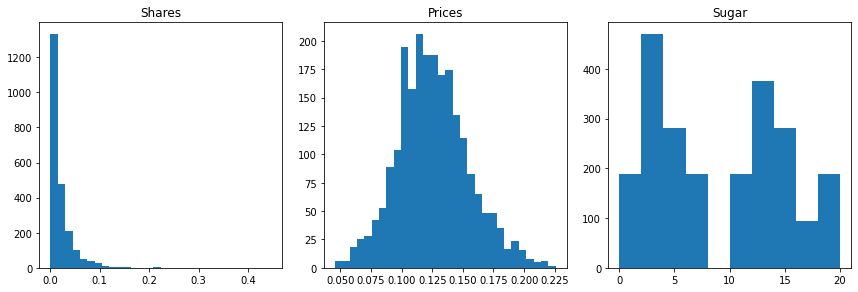

In [ ]:
# some histograms
fig, axs = plt.subplots(1, 3)

# figure specs
fig.set_figwidth(12)
fig.tight_layout()

# shares
axs[0].set_title('Shares')
axs[0].hist(product_data.shares, bins=30)

#prices
axs[1].set_title('Prices')
axs[1].hist(product_data.prices, bins=30)

#sugar
axs[2].set_title('Sugar')
axs[2].hist(product_data.sugar, bins=10)

plt.show()

---
---

## Estimation Without Demographics

> In this part we solve the problem without $d_i$ which reduces the RCs to $\beta_i \sim N(\beta, \Sigma)$



---
## Roadmap to Solving Model

1. Define a [`Formulation`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Formulation.html#pyblp.Formulation) for the (linear) demand model.

2. Define a [`Formulation`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Formulation.html#pyblp.Formulation) for the (nonlinear) demand model.

3. Define an [`Integration`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Integration.html#pyblp.Integration) configuration to solve the market share integral from several available options:

4. Combine [`Formulation`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Formulation.html#pyblp.Formulation) classes, `product_data`, and the [`Integration`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Integration.html#pyblp.Integration) configuration to construct a [`Problem`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Problem.html#pyblp.Problem).

5. Use the [`Problem.solve`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Problem.solve.html#pyblp.Problem.solve) method to estimate paramters.

> The heart of the pyBLP module are is the Problem Class


---
### Linear Demand Formulation

The variables entering the linear part of the demand model (i.e. recovering the mean utility) are denoted by $X_1$. 

> We estimate the model with product fixed effects. Thus only variables that vary across markets can be included in the linear part of the model. Therefore, coeficcients on product characteristics cannot be (directly) identified.



In [ ]:
# Linear formulation
X1_formulation = pyblp.Formulation('0 + prices', absorb='C(product_ids)' ) # formula with prices and product fixed effects (no constant!)
X1_formulation

prices + Absorb[C(product_ids)]

---
### Nonlinear Demand Formulation

The variables entering the nonlinear part of the demand model (i.e. the variables with random coeficients) are denoted by $X_2$.

> Random coefs for product characteristics -- that are constant accross markets -- can be identified. 



In [ ]:
# Nonlinear formulation
X2_formulation = pyblp.Formulation('1 + prices + sugar + mushy') # formula with constant, prices and product characteristics (no constant!)
X2_formulation

1 + prices + sugar + mushy

---
### Integration
Setting the parameters for the integration. We use monte carlo draws simulate 50 individuals from a random normal distribution.
> With pyBLP we can choose from differnt simulation methods.

In [ ]:
mc_integration = pyblp.Integration('monte_carlo', size=50, specification_options={'seed': 0})
mc_integration

Configured to construct nodes and weights with Monte Carlo simulation with options {seed: 0}.

---
### Combine Everything to Formulate a Problem
The problem is the core of the estimation, here demand forumlations, integration and **data** are combined.

> The Data we use is already "pre-labeled". If we would use different labels we can specify e.g. how we name market_ids in the data.

In [ ]:
mc_problem = pyblp.Problem((X1_formulation, X2_formulation), product_data, integration=mc_integration)

Initializing the problem ...
Absorbing demand-side fixed effects ...
Initialized the problem after 00:00:00.

Dimensions:
 T    N     F    I     K1    K2    MD    ED 
---  ----  ---  ----  ----  ----  ----  ----
94   2256   5   4700   1     4     20    1  

Formulations:
       Column Indices:           0       1       2      3  
-----------------------------  ------  ------  -----  -----
 X1: Linear Characteristics    prices                      
X2: Nonlinear Characteristics    1     prices  sugar  mushy


---
### Solve the Problem

Here we solve the problem by first specifying a an optimizer and then solving the problem. 

> For speed we restrict $\Sigma$ -- in $\beta_i \sim N(\beta, \Sigma)$ -- to be diagonal. This makes the assumption random coeficcients are uncorrelated with each other e.g. a high valuation of mushyness does not coincide with a high valuation of sugar.

In [ ]:
# Define an optimization Rule
bfgs = pyblp.Optimization('bfgs', {'gtol': 1e-4})

In [ ]:
# Solve the Problem
results1 = mc_problem.solve(sigma=np.eye(4), optimization=bfgs )

Solving the problem ...

Nonlinear Coefficient Initial Values:
Sigma:        1           prices          sugar          mushy    
------  -------------  -------------  -------------  -------------
  1     +1.000000E+00                                             
prices  +0.000000E+00  +1.000000E+00                              
sugar   +0.000000E+00  +0.000000E+00  +1.000000E+00               
mushy   +0.000000E+00  +0.000000E+00  +0.000000E+00  +1.000000E+00

Nonlinear Coefficient Lower Bounds:
Sigma:        1           prices          sugar          mushy    
------  -------------  -------------  -------------  -------------
  1         -INF                                                  
prices  +0.000000E+00      -INF                                   
sugar   +0.000000E+00  +0.000000E+00      -INF                    
mushy   +0.000000E+00  +0.000000E+00  +0.000000E+00      -INF     

Nonlinear Coefficient Upper Bounds:
Sigma:        1           prices          sugar          mu

---
### Analysis of the Results
> Some simple post-estimation results.

Computing elasticities with respect to prices ...
Finished after 00:00:00.



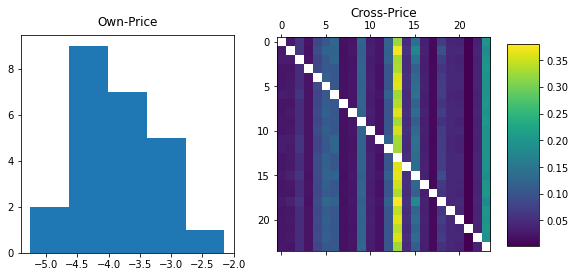

In [ ]:
# plotting elastcities
elasticities = results1.compute_elasticities()

# get elasticities
single_market_elasticities = elasticities[product_data['market_ids'] == 'C01Q1']
fig, ax = plt.subplots(1,2)
fig.set_figwidth(9)

# histogram of own price elasticities
ax[0].hist(single_market_elasticities.diagonal(), bins=5)
ax[0].set_title('Own-Price', pad=10)

# heatmap for cross price elasticities
np.fill_diagonal(single_market_elasticities, np.nan)
ax[1].matshow(single_market_elasticities, origin='lower')
ax[1].set_title('Cross-Price', pad=10)

# add colorbar on right
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.875, 0.15, 0.05, 0.7])
fig.colorbar(ax[1].matshow(single_market_elasticities), cax=cbar_ax)

plt.show()

Computing marginal costs ...
Finished after 00:00:00.

Computing markups ...
Finished after 00:00:00.



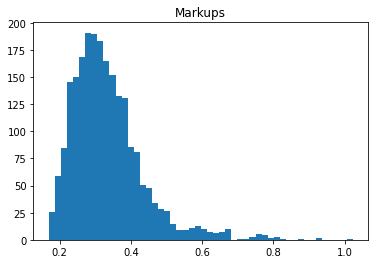

In [ ]:
# markups
costs = results1.compute_costs()
markups = results1.compute_markups(costs=costs)

# histogram of markups
fig , ax = plt.subplots(1,1)
ax.hist(markups, bins=50)
ax.set_title('Markups')
plt.show()

---
---
## Adding Demographics to the Problem

> In the RC model demographics $d_i$ enter in $\beta_i \sim N(\beta + \Pi d_i, \Sigma)$

For demographic data we need two changes:

1. `agent_data` contains pre-computed Monte Carlo draws and demographics.
2. `agent_formulation` has to be added.



---

### Agent Data

The `agent data` has several reserved column names.

- `market_ids` are the index that link the `agent data` to the `market_ids` in `product data`.
- `weights` are the weights $w_{it}$ attached to each agent. In each market, these should sum to one so that $\sum_i w_{it} = 1$. It is often the case the $w_{it} = 1 / I_t$ where $I_t$ is the number of agents in market $t$, so that each agent gets equal weight. Other possibilities include quadrature nodes and weights.
- `nodes0`, `nodes1`, ... are the nodes at which the unobserved agent tastes $\mu_{ijt}$ are evaluated i.e. draws from a (normal) distribution.
- Other fields are the (normalized) realizations of the demographics `income`, `income_squared`, `age`, `child` themselves.

In [ ]:
agent_data = pd.read_csv(pyblp.data.NEVO_AGENTS_LOCATION)
agent_data.head()

---

### Agent Formulation

The `agent formulation` defines which columns of demographic 
information to interact with $X_2$.

> We might want to come back to this.



In [ ]:
# agent formualtion
agent_formulation = pyblp.Formulation('0 + income + age + child') # exclude the constant
agent_formulation

income + age + child

---

### The Problem Formulation
We need to update the problem formulation with the agent formulation
> Because the data already includes monte carlo draws we do not have to define an integration method.

In [ ]:
nevo_problem = pyblp.Problem((X1_formulation, X2_formulation), product_data, agent_formulation, agent_data)
nevo_problem

---

### Solving the Problem 

> We assume that $\Sigma$ is diagonal and $\Pi$ is left unrestricted.

In [ ]:
# define starting sigma
initial_sigma = np.eye(4)

# define starting pi
initial_pi = np.ones(4,3)

# Define an optimization Rule
bfgs = pyblp.Optimization('bfgs', {'gtol': 1e-4})
# solve the model
results2 = nevo_problem.solve(initial_sigma, initial_pi, optimization=bfgs)
results2

---
---

## What else can be done?

* Merger Analysis with an Ownership Matrix.
* Supply side.
* Micro Moments.
* Many fixed effects.
* Other optimization method.
* ...